In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.io import loadmat
import numpy as np
import time
import sys
import os
import h5py
import math
import matplotlib.animation, matplotlib
import IPython.display as ipd

In [2]:
x = np.random.rand(10*8000*540)
x = x.reshape((10, 8000, 540))
y = np.copy(x)

mins = np.random.rand(540)
maxs = np.random.rand(540)

In [3]:
print(np.min(np.min(x, axis = 0), axis=0).shape)

(540,)


In [4]:
for i in range(10):
    for j in range(540):
         y[i, :, j] = (x[i, :, j] - mins[j])/(maxs[j] - mins[j])

In [47]:
print(y[0, 0, 0])
print(((x-mins)/(maxs-mins))[0, 0, 0])

12.33452921161494
12.33452921161494


In [48]:
print(np.array_equal(((x-mins)/(maxs-mins)), y))

True


In [2]:
def get_csi(x):
    x = np.squeeze(x["csi_trace"])
    data = []
    for i in range(x.shape[0]):
        array = {}
        array["timestamp_low"] = np.squeeze(x[i][0][0][0])
        array["bfee_count"] =  np.squeeze(x[i][0][0][1])
        array["Nrx"] = np.squeeze(x[i][0][0][2])
        array["Ntx"] = np.squeeze(x[i][0][0][3])
        array["rssi_a"] = np.squeeze(x[i][0][0][4])
        array["rssi_b"] = np.squeeze(x[i][0][0][5])
        array["rssi_c"] = np.squeeze(x[i][0][0][6])
        array["noise"] = np.squeeze(x[i][0][0][7])
        array["agc"] = np.squeeze(x[i][0][0][8])
        array["perm"] = np.squeeze(x[i][0][0][9])
        array["rate"] = np.squeeze(x[i][0][0][10])
        array["csi"] = np.squeeze(x[i][0][0][11])
        
        data.append(array)
    return data

def smooth(x,window_len):
    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    w=np.hanning(window_len)
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[(window_len//2):-(window_len//2)]

def phase_correction(ph_raw):
    m = np.arange(-28,29)
    Tp = np.unwrap(ph_raw)
    k_param = (Tp[29] - Tp[0])/(m[29] - m[0]);
    b_param = np.sum(Tp)*(1/30)

    correct_phase = []
    for i in range(30):
        correct_phase.append(Tp[i] - k_param*m[i] - b_param)
    return correct_phase

# 3 x 3 MIMO Matrix format
# [h11 h12 h13
# h21 h22 h23
# h31 h32 h33]
def apply_phcorrect(ph_raw):
    mimo_mat = np.rollaxis(ph_raw, 2, 0)
    mimo_mat = np.reshape(mimo_mat, (30, 9))

    crct_ph = []
    for col in range(9):
        crct_ph.append(phase_correction(np.array(mimo_mat)[:, col]))

    stack_crc_ph = np.vstack(crct_ph).T

    restore_ph_mat = []
    for i in range(30):
        restore_ph_mat.append(stack_crc_ph[i, :].reshape((3,3)))
    return np.array(restore_ph_mat).T

def fill_gaps(csi_trace, technique):
    timestamp = []
    amp_data = []
    ph_data = []
    rssi_a = []
    rssi_b = []
    rssi_c = []
    noise = []
    loc = []

    for ind in range(len(csi_trace)):
        csi_entry = csi_trace[ind]
        scaled_csi = get_scaled_csi(csi_entry)
        amp = np.absolute(scaled_csi)
        ph = np.angle(scaled_csi)

        amp_temp=[]
        ph_temp=[]

        if technique == 'nan':
            if csi_trace[ind]['Ntx'] == 1:
                loc.append(ind)
                ph = np.expand_dims(ph, axis=0)
                amp = np.expand_dims(amp, axis=0)

                mean_amp = np.mean(amp)
                mean_ph = np.mean(ph)

                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((2,3)) + np.nan).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((2,3)) + np.nan).reshape((3,3)))
                ph_temp = np.array(ph_temp).T
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 2:
                loc.append(ind)
                mean_amp = np.mean(amp)
                mean_ph = np.mean(ph)
                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((1,3)) + np.nan).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((1,3)) + np.nan).reshape((3,3)))
                ph_temp = np.array(ph_temp).T
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 3:
                amp_data.append(np.array(amp).T.flatten())
                ph_data.append(apply_phcorrect(ph).T.flatten())

        elif technique == 'mean':
            if csi_trace[ind]['Ntx'] == 1:
                loc.append(ind)
                ph = np.expand_dims(ph, axis=0)
                amp = np.expand_dims(amp, axis=0)

                mean_amp = np.mean(amp)
                mean_ph = np.mean(ph)

                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((2,3)) + mean_amp).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((2,3)) + mean_ph).reshape((3,3)))
                ph_temp = np.array(ph_temp).T
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 2:
                loc.append(ind)
                mean_amp = np.mean(amp)
                mean_ph = np.mean(ph)
                for i in range(30):
                    amp_temp.append(np.append(amp[:,:,i], np.zeros((1,3)) + mean_amp).reshape((3,3)))
                    ph_temp.append(np.append(ph[:,:,i], np.zeros((1,3)) + mean_ph).reshape((3,3)))
                ph_temp = np.array(ph_temp).T
                amp_data.append(np.array(amp_temp).flatten())
                ph_data.append(apply_phcorrect(ph_temp).flatten())

            elif csi_trace[ind]['Ntx'] == 3:
                amp_data.append(np.array(amp).T.flatten())
                ph_data.append(apply_phcorrect(ph).T.flatten())
                
        elif technique == 'copy':
            if csi_trace[ind]['Ntx'] == 1:
                loc.append(ind)
                amp_data.append(amp_data[-1])
                ph_data.append(ph_data[-1])
                
            elif csi_trace[ind]['Ntx'] == 2:
                loc.append(ind)
                amp_data.append(amp_data[-1])
                ph_data.append(ph_data[-1])

            elif csi_trace[ind]['Ntx'] == 3:
                amp_data.append(np.array(amp).T.flatten())
                ph_data.append(apply_phcorrect(ph).T.flatten())
    
    return np.hstack([amp_data, ph_data]), loc

def dbinv(x):
    return np.power(10, (np.array(x)/10))

def get_total_rss(csi_st):
    rssi_mag = 0;
    if csi_st['rssi_a'] != 0:
        rssi_mag = rssi_mag + dbinv(csi_st['rssi_a'])

    if csi_st['rssi_b'] != 0:
        rssi_mag = rssi_mag + dbinv(csi_st['rssi_b'])

    if csi_st['rssi_c'] != 0:
        rssi_mag = rssi_mag + dbinv(csi_st['rssi_c'])

    return 10*np.log10(rssi_mag) - 44 - csi_st['agc']

def get_scaled_csi(csi_st):
    csi = csi_st['csi']

    csi_sq = np.multiply(csi, np.conj(csi))
    csi_pwr = np.sum(csi_sq[:])
    rssi_pwr = dbinv(get_total_rss(csi_st))

    scale = rssi_pwr / (csi_pwr / 30)

    if (csi_st['noise'] == -127):
        noise_db = -92
    else:
        noise_db = csi_st['noise']

    thermal_noise_pwr = dbinv(noise_db)
    quant_error_pwr = scale * (csi_st['Nrx'] * csi_st['Ntx'])
    total_noise_pwr = thermal_noise_pwr + quant_error_pwr;

    ret = csi * np.sqrt(scale / total_noise_pwr);
    if csi_st['Ntx'] == 2:
        ret = ret * np.sqrt(2);
    elif csi_st['Ntx'] == 3:
        ret = ret * np.sqrt(dbinv(4.5));

    return ret

def read_samples(dataset_path, endswith=".csv"):
    datapaths, labels = list(), list()
    label = 0
    classes = sorted(os.walk(dataset_path).__next__()[1])

    # List each sub-directory (the classes)
    for c in classes:
        c_dir = os.path.join(dataset_path, c)
        walk = os.walk(c_dir).__next__()
        # Add each image to the training set
        for sample in walk[2]:
            # Only keeps csv samples
            if sample.endswith(endswith):
                datapaths.append(os.path.join(c_dir, sample))
                labels.append(label)
        label += 1

    return datapaths, labels

def compute_data(file_path):
    if (not os.path.isfile(file_path)):
        raise ValueError("File dosn't exits")

    csi_trace = get_csi(loadmat(file_path))[2000:10000]
    X_amp, X_ph = fill_gaps(csi_trace, technique='mean')

    if ((X_amp.shape != (8000, 270)) or (X_ph.shape != (8000, 270))):
        print(X_amp.shape, X_ph.shape, file_path)
        return

    path, file = os.path.split(file_path)
    _, class_name = os.path.split(path)

    file = os.path.splitext(file)[0]

    file_name = os.path.join(os.path.join(dest_path, class_name), (file+".csv"))
    np.savetxt(file_name, np.hstack([X_amp, X_ph]), delimiter=',')
    
def get_csi_ri(csi_trace):
    real_data = []
    imag_data = []
    complex_data = []

    for ind in range(len(csi_trace)):
        csi_entry = csi_trace[ind]
        scaled_csi = get_scaled_csi(csi_entry)
    
        real_data.append(scaled_csi.real.flatten())
        imag_data.append(scaled_csi.imag.flatten())
        complex_data.append(np.square(np.abs(scaled_csi)).flatten())
        
    return np.array(real_data), np.array(imag_data), np.array(complex_data)

In [30]:
csi_trace = get_csi(loadmat("/home/kalvik/Documents/neuralwave/data/aka1.mat"))
csi_trace = fill_gaps(csi_trace, technique="mean")

In [53]:
data = np.copy(csi_trace[0][3500:7500, 0])
x = np.arange(1, 3, 1/2000)
data[:] = smooth(data[:], 91)

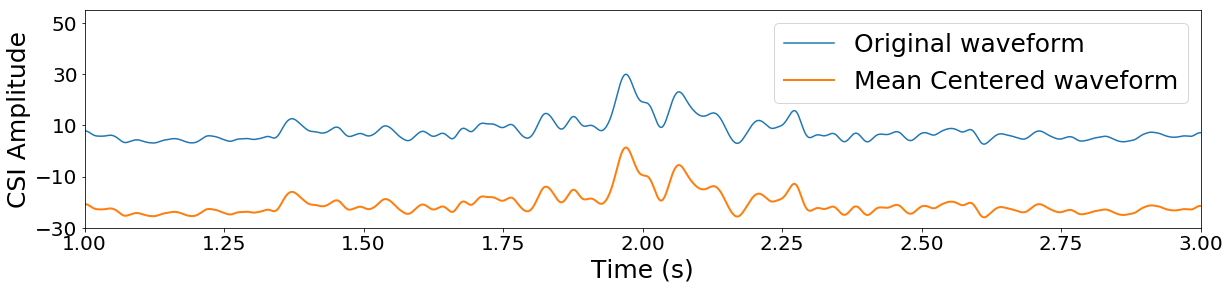

In [75]:
plt.figure(figsize=(20,4))
plt.plot(x, data, label='Original waveform')
plt.plot(x, data-dict['means'][0], linewidth=2, label='Mean Centered waveform')
plt.ylabel("CSI Amplitude", fontsize= 25)
plt.xlabel("Time (s)", fontsize= 25)
plt.xlim((1, 3))
plt.ylim((-30, 55))
plt.xticks(fontsize=20)
plt.yticks(np.arange(-30, 51, 20), fontsize=20)
plt.legend(loc='upper right', prop={'size': 25})
plt.savefig("/home/kalvik/Documents/neuralwave/data/data_mean.png", bbox_inches='tight', dpi=150)

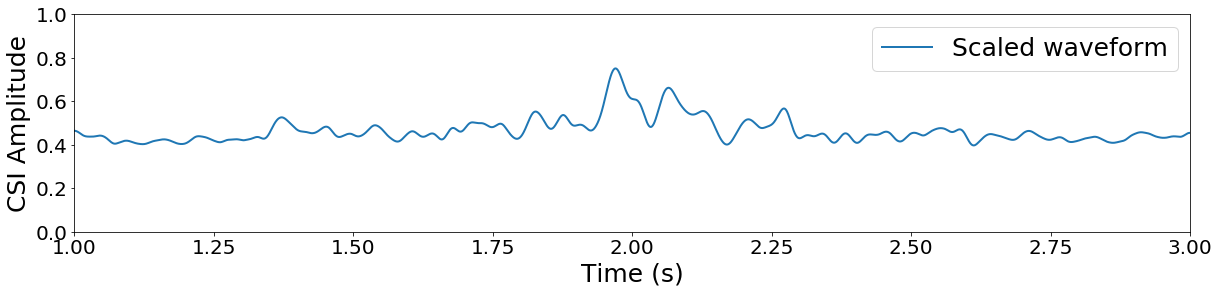

In [78]:
plt.figure(figsize=(20,4))
plt.plot(x, (data-dict['mins'][0])/(dict['maxs'][0]-dict['mins'][0]), linewidth=2, label='Scaled waveform')
plt.ylabel("CSI Amplitude", fontsize= 25)
plt.xlabel("Time (s)", fontsize= 25)
plt.xlim((1, 3))
#plt.ylim((-30, 55))
plt.xticks(fontsize=20)
plt.yticks(np.arange(0, 1.1, 0.2)
plt.legend(loc='upper right', prop={'size': 25})
plt.savefig("/home/kalvik/Documents/neuralwave/data/data_scale.png", bbox_inches='tight', dpi=150)

In [13]:
import pickle
fileObject = open('/home/kalvik/Documents/neuralwave/data/CSI_30_l2_AMP_4000_94_data_scalers.pkl','rb')
dict = pickle.load(fileObject)
fileObject.close() 

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator PCA from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [ ]:
plt.figure(figsize=(20,4))
plt.plot(x, data, label='Original waveform')
plt.plot(x, smooth_data, '', linewidth=2, label='Denoised waveform')
plt.ylabel("CSI Amplitude", fontsize= 25)
plt.xlabel("Time (s)", fontsize= 25)
plt.xlim((1, 3))
plt.ylim((0, 40))
plt.xticks(fontsize=20)
plt.yticks(np.arange(0, 41, 20), fontsize=20)
plt.legend(loc='upper right', prop={'size': 25})
plt.savefig("/home/kalvik/Documents/neuralwave/data/data_smooth.png", bbox_inches='tight', dpi=150)

In [130]:
x = np.arange(1, 3, 1/2000)
data = csi_trace[0][3500:7500, 0]
smooth_data = smooth(data, 91)

print(x.shape, data.shape)

(4000,) (4000,)


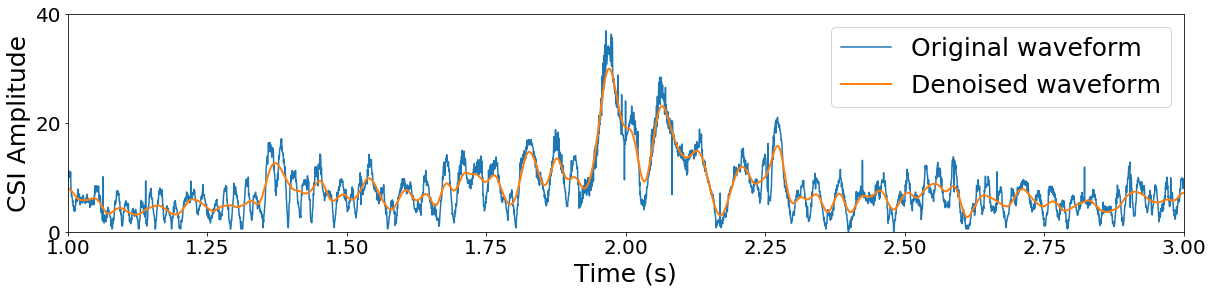

In [170]:
plt.figure(figsize=(20,4))
plt.plot(x, data, label='Original waveform')
plt.plot(x, smooth_data, '', linewidth=2, label='Denoised waveform')
plt.ylabel("CSI Amplitude", fontsize= 25)
plt.xlabel("Time (s)", fontsize= 25)
plt.xlim((1, 3))
plt.ylim((0, 40))
plt.xticks(fontsize=20)
plt.yticks(np.arange(0, 41, 20), fontsize=20)
plt.legend(loc='upper right', prop={'size': 25})
plt.savefig("/home/kalvik/Documents/neuralwave/data/data_smooth.png", bbox_inches='tight', dpi=150)

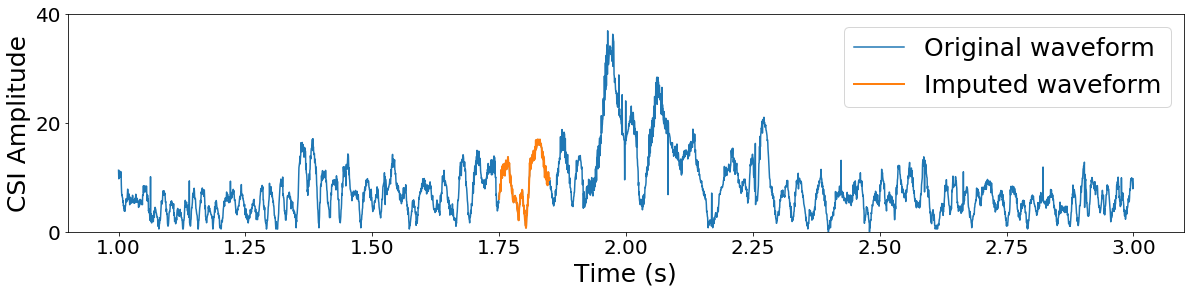

In [171]:
plt.figure(figsize=(20,4))
plt.plot(x, data, label='Original waveform')
plt.plot(x[1500:1700], data[1500:1700], linewidth=2, label='Imputed waveform')
plt.ylabel("CSI Amplitude", fontsize= 25)
plt.xlabel("Time (s)", fontsize= 25)
plt.ylim((0, 40))
plt.xticks(fontsize=20)
plt.yticks(np.arange(0, 41, 20), fontsize=20)
plt.legend(loc='upper right', prop={'size': 25})
plt.savefig("/home/kalvik/Documents/neuralwave/data/data_impute.png", bbox_inches='tight', dpi=150)

In [ ]:
csi_trace = get_csi(loadmat("/home/kalvik/Documents/neuralwave/data/sam7.mat"))
_, _, complx = get_csi_ri(csi_trace)

In [ ]:
for i in range(270):
    plt.figure(figsize=(20,10))
    plt.plot(complx[:, i])
    plt.plot(smooth(complx[:, i], 91))
    plt.show()

In [ ]:
csi_trace = get_csi(loadmat("/home/kalvik/Documents/neuralwave/data/sam7.mat"))

for i in range(10):
    real, imag = get_csi_ri(csi_trace, i)
    plt.scatter(real, imag)
    plt.show()

In [ ]:
csi_trace = get_csi(loadmat("/home/kalvik/Documents/neuralwave/data/aka36.mat"))

def fill_gaps_test(csi_trace, i):
    real_data = []
    imag_data = []

    for ind in range(len(csi_trace)):
        csi_entry = csi_trace[ind]
        scaled_csi = get_scaled_csi(csi_entry)
    
        real_data.append(scaled_csi.real.flatten()[i])
        imag_data.append(scaled_csi.imag.flatten()[i])
        
    return np.array(real_data), np.array(imag_data)

for i in range(10):
    real, imag = fill_gaps_test(csi_trace, i)
    plt.figure(figsize=(10,10))
    plt.scatter(real, imag)
    plt.show()

In [ ]:
csi_trace = get_csi(loadmat("/home/kalvik/Documents/neuralwave/data/sam7.mat"))

csi_trace_c, loc = fill_gaps(csi_trace, technique='copy')
csi_trace_m, loc = fill_gaps(csi_trace, technique='mean')
#csi_trace_n, loc = fill_gaps(csi_trace, technique='nan')

for i in range(10):
    plt.figure(figsize=(20,10))
    [plt.axvline(j, color='k', linestyle='dashed', linewidth=1) for j in loc]
    plt.plot(csi_trace_m[:, i])
    plt.plot(smooth(csi_trace_m[:, i], 91))
    plt.show()
    
    plt.figure(figsize=(20,10))
    [plt.axvline(j, color='k', linestyle='dashed', linewidth=1) for j in loc]
    plt.plot(csi_trace_c[:, i])
    plt.plot(smooth(csi_trace_c[:, i], 91))
    plt.show()

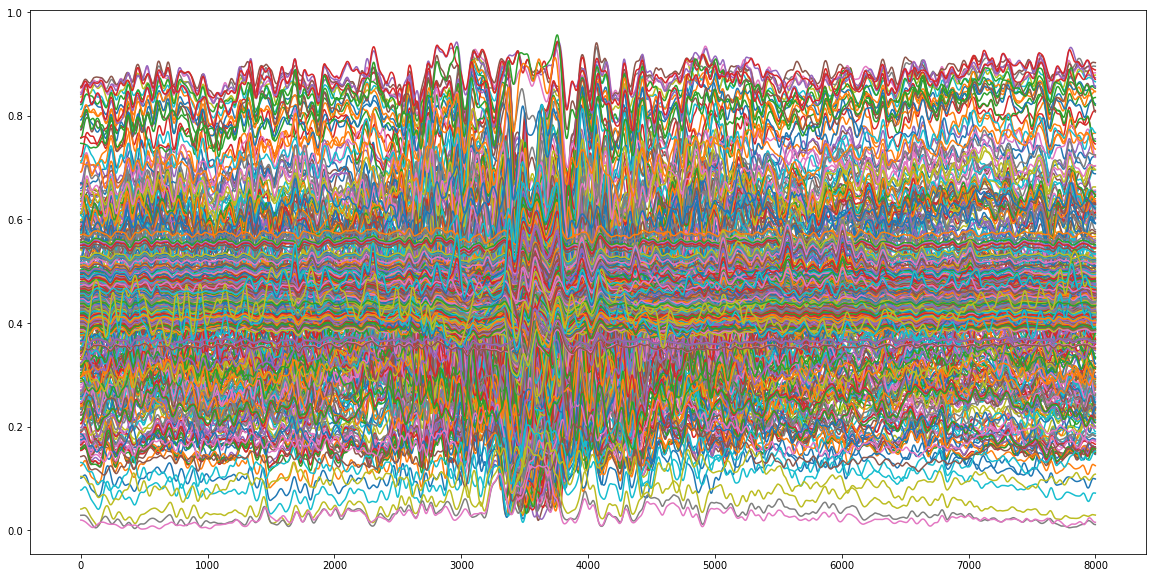

In [14]:
x = np.loadtxt(open("/home/kalvik/Documents/neuralwave/data/aka47.csv", "rb"), delimiter=",")
plt.figure(figsize=(20,10))
for i in range(x.shape[-1]):
    plt.plot(x[:, i])
plt.show()

In [ ]:
x = []
print(np.array(x).shape)

["timestamp_low"]
["rssi_a"]
["rssi_b"]
["rssi_c"]
["noise"]

In [ ]:
x = []
for i in range(3306,3311):
    x.append(csi_trace[i]["timestamp_low"])
plt.plot(x)
plt.show()

print(x)

In [ ]:
x = []
for i in range(len(csi_trace)):
    x.append(csi_trace[i]["noise"])
plt.plot(x)
plt.show()

In [6]:
data_path = "/home/kalvik/Documents/neuralwave/data/mc/CSI_30_l2_1.h5"

hf = h5py.File(data_path, 'r')
X_train = np.array(hf.get('X_train'))
X_test = np.array(hf.get('X_test'))
y_train = np.eye(30)[hf.get('y_train')]
y_test = np.eye(30)[hf.get('y_test')]
hf.close()

print(X_train.shape)

(1107, 99)
